<a href="https://colab.research.google.com/github/venkatalakshmi03/CMPE256/blob/main/BERT_weights_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 77 kB 8.7 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
     |████████████████████████████████| 880 kB 83.0 MB/s 
     |████████████████████████████████| 596 kB 67.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=42f0f471646d42b0a0461c96cc935ccfb3000b575b2fa401c0fb757f799ddf92
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

In [5]:
!unzip /content/drive/MyDrive/Reviews.csv.zip

Archive:  /content/drive/MyDrive/Reviews.csv.zip
  inflating: Reviews.csv             


In [6]:
data_path = "/content/Reviews.csv"

In [7]:
df = pd.read_csv(data_path)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
np.unique(df.Score,return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 52268,  29769,  42640,  80655, 363122]))

In [10]:
print("Negative review count:",sum(df.Score <=2))
print("Positive review count:",sum(df.Score >3))

Negative review count: 82037
Positive review count: 443777


In [11]:
df.loc[df['Score'] <=2, 'Sentiment'] = int(0)
df.loc[df['Score'] > 3, 'Sentiment'] = int(1)

In [12]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0


In [13]:
df.drop(df[df['Score']==3].index,inplace=True)

In [14]:
df.shape

(525814, 11)

In [15]:
np.unique(df.Score,return_counts=True)

(array([1, 2, 4, 5]), array([ 52268,  29769,  80655, 363122]))

In [16]:
print("Negative review count:",sum(df.Score <=2))
print("Positive review count:",sum(df.Score >3))

Negative review count: 82037
Positive review count: 443777


In [17]:
df_sentiment = df[['Text','Sentiment']]

In [18]:
df_sentiment.head()

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1.0
1,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,This is a confection that has been around a fe...,1.0
3,If you are looking for the secret ingredient i...,0.0
4,Great taffy at a great price. There was a wid...,1.0


In [19]:
np.unique(df_sentiment.Sentiment, return_counts=True)

(array([0., 1.]), array([ 82037, 443777]))

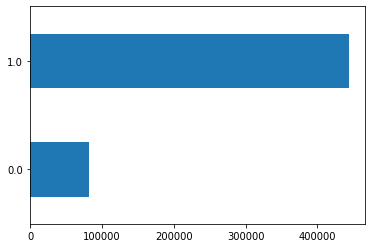

In [20]:
df_sentiment.Sentiment.value_counts().sort_values().plot(kind = 'barh')

In [21]:
from bs4 import BeautifulSoup
import re,string,unicodedata

In [22]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df_sentiment['Text']=df_sentiment['Text'].apply(denoise_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
df_sentiment.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [24]:
df_sentiment.head()

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1.0
1,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,This is a confection that has been around a fe...,1.0
3,If you are looking for the secret ingredient i...,0.0
4,Great taffy at a great price. There was a wid...,1.0


In [25]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [26]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)

In [28]:
df_sentiment.Text = df_sentiment.Text.apply(stem_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
df_sentiment.head()

,Text,Sentiment
0,bought sever vital can dog food product found ...,1.0
1,product arriv label jumbo salt peanuts...th pe...,0.0
2,"confect around centuries. light, pillowi citru...",1.0
3,look secret ingredi robitussin believ found it...,0.0
4,great taffi great price. wide assort yummi taf...,1.0


In [30]:
import os 
df_sentiment.to_csv('/content/processed_df.csv')

In [31]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [32]:
class AmazonFineFoodReviews(torch.utils.data.Dataset):
    
    def __init__(self, df):
        
        self.df = df
        self.maxlen = 256
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        review = self.df['Text'].iloc[index].split()
        review = ' '.join(review)
        sentiment = int(self.df['Sentiment'].iloc[index])

        encodings = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.maxlen,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encodings.input_ids.flatten(),
            'attention_mask': encodings.attention_mask.flatten(),
            'labels': torch.tensor(sentiment, dtype=torch.long)
        }

In [33]:
train_df, test_df = train_test_split(df_sentiment, test_size=0.3, random_state=42)
len(train_df), len(test_df)

(368069, 157745)

In [34]:
train_dataset = AmazonFineFoodReviews(train_df)
valid_dataset = AmazonFineFoodReviews(test_df)


In [35]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32
)

In [36]:
np.unique(train_loader.dataset.df['Sentiment'])

array([0., 1.])

In [37]:
for batch in train_loader:
    print(batch['input_ids'].shape)
    print(batch['attention_mask'].shape)
    print(batch['labels'].shape)
    break

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


In [38]:
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.drop0 = nn.Dropout(0.25)
        self.linear1 = nn.Linear(3072, 512)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.25)
        self.linear2 = nn.Linear(512, 2)
        self.relu2 = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        pooled_output = torch.cat(tuple([last_hidden_state[:, i] for i in [-4, -3, -2, -1]]), dim=-1)
        x = self.drop0(pooled_output)
        x = self.relu1(self.linear1(x))
        x = self.drop1(x)
        x = self.relu2(self.linear2(x))
        return x

In [39]:
model = SentimentClassifier()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [40]:
np.array(train_loader.dataset.df['Sentiment'])

array([1., 1., 1., ..., 1., 1., 1.])

In [41]:
class_weights=class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_loader.dataset.df['Sentiment']),
    y = np.array(train_loader.dataset.df['Sentiment'])
)

In [42]:
class_weights=torch.tensor(class_weights,dtype=torch.float)

In [43]:
print(class_weights)

tensor([3.2055, 0.5924])


In [44]:
criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
epochs = 2

In [45]:
for epoch in range(epochs):
    
  # TRAIN
    model.train()
    train_loop = tqdm(train_loader)
    for batch in train_loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        output = model(input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loop.set_description(f"Training Epoch: {epoch}")
        train_loop.set_postfix(loss=loss.item())

  0%|          | 0/11503 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  


  0%|          | 0/11503 [00:00<?, ?it/s]

In [57]:
valid_loop = next(iter(valid_loader))

In [74]:
# # VALIDATION
# val_accuracy = []
# all_output = []
import torch.nn.functional as F

model.eval()
batch = next(iter(valid_loader))

input_ids = batch['input_ids'].to('cpu')
attention_mask = batch['attention_mask'].to('cpu')
labels = batch['labels'].to('cpu')
    
output = model(input_ids, attention_mask).to('cpu')
# all_output.append(output)
    
# loss = criterion(output, labels).to('cpu')
preds = torch.argmax(output, dim=1).flatten().to('cpu')
    
    # accuracy = (preds == labels).cpu().numpy().mean() * 100
    # val_accuracy.append(accuracy)
    
# valid_loop.set_description(f"Validation Epoch: {epoch}")
# valid_loop.set_postfix(loss=loss.item())
# val_accuracy = np.mean(val_accuracy)
# all_output = torch.cat(output, dim=0)
probs = F.softmax(output, dim=1).cpu().detach().numpy()

In [52]:
test_sample = test_df['Text'].iloc[100]
original_label = test_df['Sentiment'].iloc[100]

print(test_sample)
print(original_label)

encodings = tokenizer.encode_plus(
    test_sample,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

with torch.no_grad():
    model.to('cpu')
    preds = model(encodings['input_ids'].to('cpu'), encodings['attention_mask'].to('cpu'))
    preds = np.argmax(preds)
    output = preds.item()
    print(output+1)

eat hemp seed heart breakfast sinc aug. 15, 2011. love them!! i'v lost 15 pound appetit significantli reduc energi level great. eat big salad morn 2oz. hemp seeds, plain yogurt mrs. dash spices. sinc august, i'v salad 6 times. weekend eat like 'normal person', can't wait go back eat salad breakfast. acid reflux gone, i'm longer bloat gassy. hemp seed full nutrit plan eat rest life (i'm 52).
1.0
1


In [75]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.5000
Accuracy: 81.25%


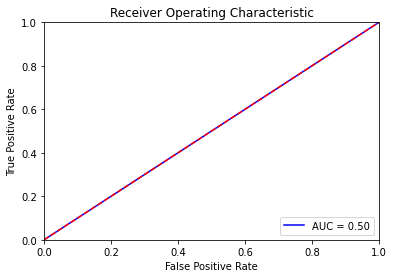

In [77]:
evaluate_roc(probs, labels)

In [82]:
predictions = np.array([np.argmax(x)+1 for x in probs])

In [83]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [85]:
from sklearn.metrics import classification_report
print(classification_report(predictions,labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.81      0.90        32

    accuracy                           0.81        32
   macro avg       0.50      0.41      0.45        32
weighted avg       1.00      0.81      0.90        32



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
